In [1]:
import src.data as d
import src.drawer as drawer
import numpy as np
import math
import importlib
importlib.reload(d)
importlib.reload(drawer)
 

# load data
source_data, markers = d.load_data("data/ocr.dat", 2, False)
# source_data, markers = d.load_compact_clusters(100, 10, alpha=3.0)
# source_data, markers = d.load_noise(200, 10)

# remove outliers
source_data, markers = d.filter(source_data, markers, 2*3*math.sqrt(3))
print('filtered:', len(source_data[0]))

# sorting by varience
source_std_dev = np.std(source_data,1)
d.sort(source_data, source_std_dev)

# calculate cov. matrix and eigen values & vectors
source_cov_mat = np.cov(source_data)
source_e_vals, source_e_vecs = np.linalg.eig(source_cov_mat)

file dim: 25
file len: 840
real len: 420
filtered: 420


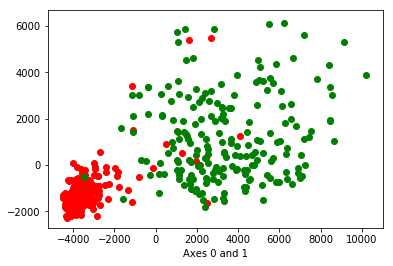

In [3]:
drawer.plot_2d(source_data, markers, 0,1, "Axes 0 and 1").show()

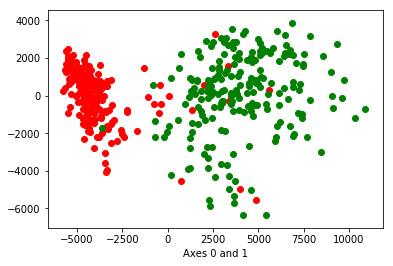

In [4]:
#PCA 
import src.pca as pca
importlib.reload(pca)

pca_data, pca_error = pca.calculate(source_data)
drawer.plot_2d(pca_data, markers, 0, 1, "Axes 0 and 1").show()

Complex calculations! Its may take few minutes.
1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..


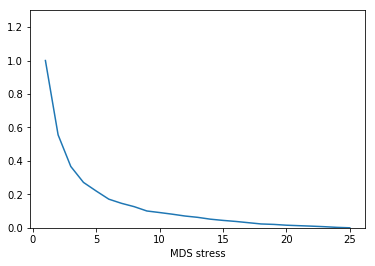

Expected dimensionality: 4


In [5]:
#MDS
import src.mds as mds
importlib.reload(mds)

mds_data_list = [] 
mds_distances = np.empty(len(source_data))
mds_prepared = mds.init(source_data)


print('Complex calculations! Its may take few minutes.')
for i in range(1, len(mds_distances)+1):
    print(i,end='..')
    proj, distance = mds_prepared.calculate(i, eps=0.0005)
    mds_data_list.append(proj)
    mds_distances[i-1] = distance
print()

mds_distances /= max(mds_distances)
drawer.plot_line(mds_distances, label='MDS stress').show()
print("Expected dimensionality:", d.real_dimensionality(mds_distances, 0.15))

Complex calculations! Its may take few minutes.
1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..


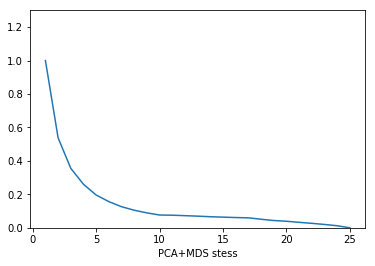

Expected dimensionality: 5


In [6]:
# PCA + MDS
import src.mds as mds
importlib.reload(mds)

pca_mds_data_list = [] 
pca_mds_distances = np.empty(len(pca_data))
pca_mds_prepared = mds.init(pca_data)

print('Complex calculations! Its may take few minutes.')
for i in range(1, len(pca_mds_distances)+1):
    print(i,end='..')
    proj, distance = pca_mds_prepared.calculate(i, eps=0.0005)
    pca_mds_data_list.append(proj)
    pca_mds_distances[i-1] = distance
print()

pca_mds_distances /= max(pca_mds_distances)
drawer.plot_line(pca_mds_distances, label='PCA+MDS stess').show()
print("Expected dimensionality:", d.real_dimensionality(pca_mds_distances, 0.15))

Expected dimensionality:
SRC: 13
PCA: 10
MDS: 7
PCA+MDS: 8


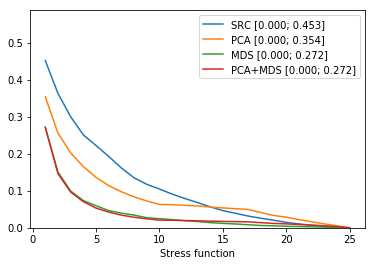

In [7]:
# Stress function by distance between points
importlib.reload(d)
from scipy.spatial import distance as scipy_distance

src_stress_d = []
pca_stress_d = []
mds_stress_d = []
pca_mds_stress_d = []

for i in range(len(source_data)):
    src_stress_d.append(d.stress(source_data, source_data[:i+1]))
    pca_stress_d.append(d.stress(source_data, pca_data[:i+1]))
    mds_stress_d.append(d.stress(source_data, mds_data_list[i]))
    pca_mds_stress_d.append(d.stress(source_data, pca_mds_data_list[i]))

# max_val = max(max(src_stress_d, src_stress_d, mds_stress_d, pca_mds_stress_d))
src_data_t = source_data.transpose()
max_val = np.sum(scipy_distance.cdist(src_data_t,src_data_t))

src_stress_d /= max_val
pca_stress_d /= max_val
mds_stress_d /= max_val
pca_mds_stress_d /= max_val

stress_list = [src_stress_d, pca_stress_d, mds_stress_d, pca_mds_stress_d]
legend_list = ['SRC', 'PCA', 'MDS', 'PCA+MDS']

print('Expected dimensionality:')
for i in range(len(stress_list)):
    dim = d.real_dimensionality(stress_list[i], epsilon = 0.05)
    print(f'{legend_list[i]}: {dim}')

drawer.plot_multiline(
    [src_stress_d, pca_stress_d, mds_stress_d, pca_mds_stress_d], 
    label='Stress function', 
    legend=legend_list
    ).show()

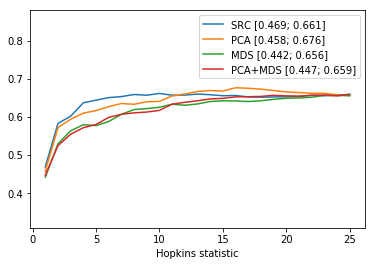

In [8]:
# Hopkins statistic
import src.hopkins as hopkins
importlib.reload(hopkins)

source_hopkins = []
pca_hopkins = []
mds_hopkins = []
pca_mds_hopkins = []

for i in range(1, len(source_data)+1): 
    source_hopkins.append(hopkins.calculate(source_data[:i]))
    pca_hopkins.append(hopkins.calculate(pca_data[:i]))
    mds_hopkins.append(hopkins.calculate(mds_data_list[i-1]))
    pca_mds_hopkins.append(hopkins.calculate(pca_mds_data_list[i-1]))

drawer.plot_multiline(
    [source_hopkins, pca_hopkins, mds_hopkins, pca_mds_hopkins], 
    label='Hopkins statistic', 
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS'],
    ).show()

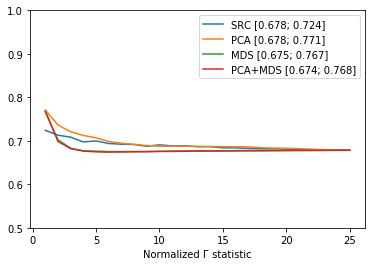

In [10]:
# Hubert statistic (common and modified)

import src.hubert as hubert
from scipy.spatial import distance
importlib.reload(hubert)
importlib.reload(drawer)

source_hubert = []
pca_hubert = []
mds_hubert = []
pca_mds_hubert = []

# calculate Hubert Г statistic
def calc_hubert():
    for i in range(1, len(source_data)+1):
        source_hubert.append(hubert.calculate(source_data[:i], markers))
        pca_hubert.append(hubert.calculate(pca_data[:i], markers))
        mds_hubert.append(hubert.calculate(mds_data_list[i-1], markers))
        pca_mds_hubert.append(hubert.calculate(pca_mds_data_list[i-1], markers))

# calculate normalize Hubert Г statistic
def calc_hubert_norm():
    for i in range(1, len(source_data)+1):
        source_hubert.append(hubert.calculate_norm(source_data[:i], markers))
        pca_hubert.append(hubert.calculate_norm(pca_data[:i], markers))
        mds_hubert.append(hubert.calculate_norm(mds_data_list[i-1], markers))
        pca_mds_hubert.append(hubert.calculate_norm(pca_mds_data_list[i-1], markers))

# label = 'Hubert\'s Г statistic'
# calc_hubert()

label = 'Normalized Г statistic'
calc_hubert_norm()

drawer.plot_multiline(
    [source_hubert, pca_hubert, mds_hubert, pca_mds_hubert], 
    label=label,
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS'],
    top=1,
    bottom=0.5
    ).show()

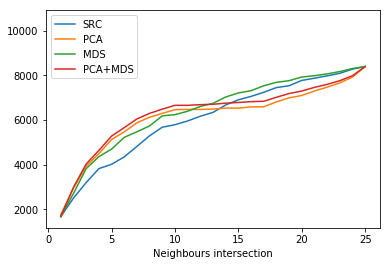

In [11]:
# Neighbours intersection error

importlib.reload(d)

def intersect_sum(s1, s2):
    res_sum = 0
    for i in range(len(s1)):
        res_sum += len(s1[i] & s2[i])
    return res_sum

ngbrs_num = 20
sourse_nbrs = d.points_neighbours(source_data,ngbrs_num)
src_nbrs_error = []
pca_nbrs_error = []
mds_nbrs_error = []
pca_mds_nbrs_error = []


for i in range(len(source_data)):
    src_nbrs_error.append(intersect_sum(sourse_nbrs, d.points_neighbours(source_data[:i+1],ngbrs_num)))
    pca_nbrs_error.append(intersect_sum(sourse_nbrs, d.points_neighbours(pca_data[:i+1],ngbrs_num)))
    mds_nbrs_error.append(intersect_sum(sourse_nbrs, d.points_neighbours(mds_data_list[i],ngbrs_num)))
    pca_mds_nbrs_error.append(intersect_sum(sourse_nbrs, d.points_neighbours(pca_mds_data_list[i],ngbrs_num)))

drawer.plot_multiline(
    [src_nbrs_error, pca_nbrs_error, mds_nbrs_error, pca_mds_nbrs_error], 
    label='Neighbours intersection', 
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS'],
    show_range=False
    ).show()

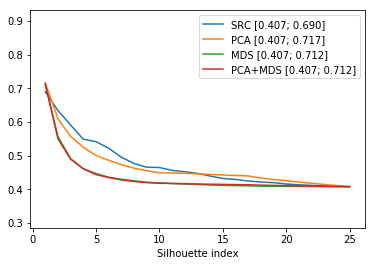

In [12]:
"""
Silhouette index
Lies in range from -1 to 1

https://en.wikipedia.org/wiki/Silhouette_(clustering)
"""

import src.silhouette  as sil
importlib.reload(sil)

src_sil = []
pca_sil = []
mds_sil = []
pca_mds_sil = []

for i in range(len(source_data)):
    src_sil.append(sil.calculate(source_data[:i+1], markers))
    pca_sil.append(sil.calculate(pca_data[:i+1], markers))
    mds_sil.append(sil.calculate(mds_data_list[i], markers))
    pca_mds_sil.append(sil.calculate(pca_mds_data_list[i], markers))

drawer.plot_multiline(
    [src_sil, pca_sil, mds_sil, pca_mds_sil], 
    label='Silhouette index', 
    legend=['SRC', 'PCA', 'MDS', 'PCA+MDS']
    ).show()

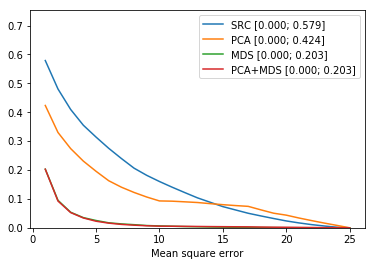

In [13]:

def calc_err(points):
    points_copy = points.copy()

    for i in range(len(points_copy)):
        points_copy -= points_copy.mean()

    if (len(points) == 1):
        return np.var(points[0])
    else:
        cov_mat = np.cov(points)
        e_vals, e_vecs = np.linalg.eig(cov_mat)
        return sum(e_vals)


dim = len(mds_data_list)

src_err = np.empty(dim)
pca_err =  np.empty(dim)
mds_err =  np.empty(dim)
pca_mds_err = np.empty(dim)
for i in range(0, len(mds_data_list)):
    src_err[i] = calc_err(source_data[:i+1])
    pca_err[i] = calc_err(pca_data[:i+1])
    mds_err[i] = calc_err(mds_data_list[i])
    pca_mds_err[i] = calc_err(pca_mds_data_list[i])

err_list = [src_err, pca_err, mds_err, pca_mds_err]
for l in err_list:
    var = l.max()
    for i in range(len(l)):
        l[i] = (var - l[i]) / var

drawer.plot_multiline(err_list, legend=['SRC', 'PCA', 'MDS', 'PCA+MDS'], label='Mean square error').show()